# Looking for global fit (standard GLM-HMM) for PWM animals with Iris' code (faster)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
import scipy.io as sio
import seaborn as sns
import scipy.optimize
import pickle
import pandas as pd
from analysis_utils import *
sns.set_context("talk")

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils, analysis
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize

# code from Brody Summer Project
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

sns.set_context("talk")

In [2]:
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


[[1.]]
[[0.971 0.029]
 [0.013 0.987]]
[[0.965 0.028 0.008]
 [0.01  0.982 0.008]
 [0.009 0.027 0.964]]


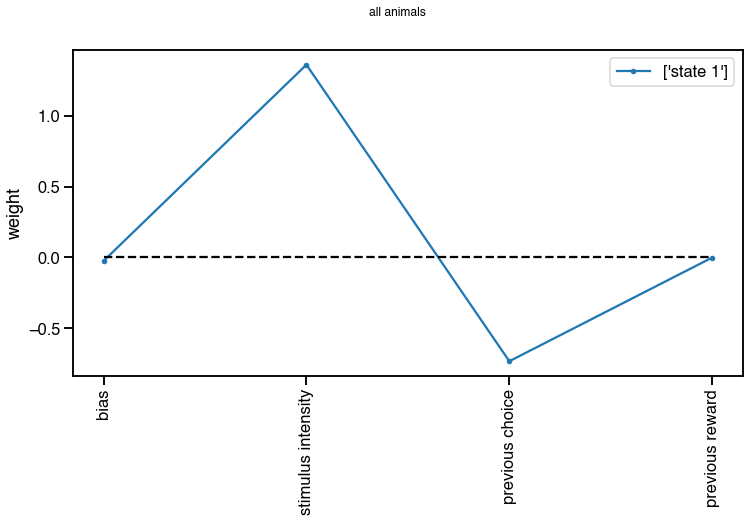

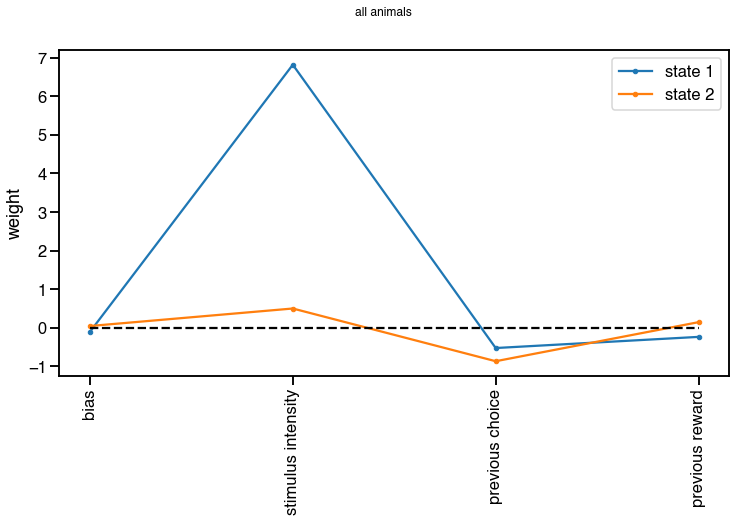

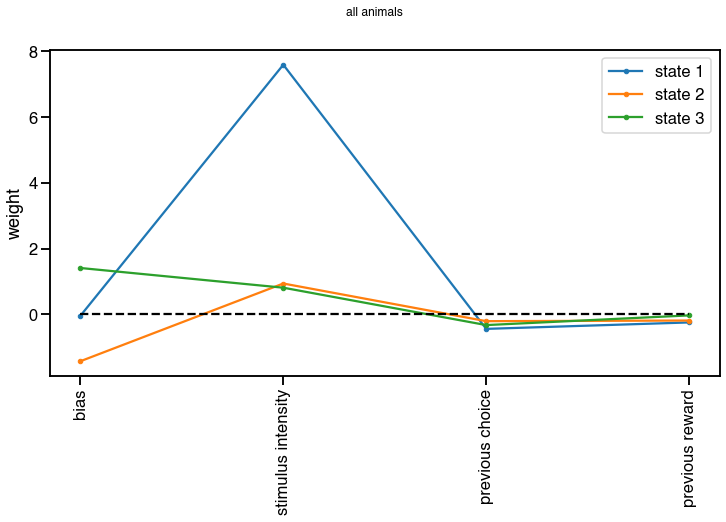

In [6]:
# saving paramters and visualizing weights
D = 4
subject = 'ibl_witten_15'
for K in [1,2,3]:
    bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_allAnimals_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'rb'))

    # # Iris' visualization
    # # for easy comparison permute the states in order from highest to lowest self-transition probability
    # A_permuted, order = permute_states(bestGLMHMM.A)
    # w_permuted,_ = permute_states(bestGLMHMM.w,method='order',param='weights',order=order)
    # print(np.round(A_permuted, 3))
    # xlabels = ['bias', 'stimulus intensity','previous choice','previous reward'] # D=4
    # legend = []
    # fig, axes = plt.subplots(1,figsize=(12,6))
    # fig.suptitle('all animals')
    # for i in range(1,K+1):
    #     legend.append('state ' + str(i))
    # visualize.plot_weights(-w_permuted[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-',error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
    # axes.legend()

    # my visualization
    print(np.round(bestGLMHMM.A,3))
    x, y, sessInd = x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=-1, D=D)
    A_permuted, order = permute_states(bestGLMHMM.A)
    w_permuted,_ = permute_states(bestGLMHMM.w,method='order',param='weights',order=order)
    wTemp = w_permuted
    wTemp[:,:,:] = - wTemp[:,:,:] # all weights have opposite sign in my code vs Iris'
    w = np.repeat(wTemp[np.newaxis], sessInd[-1], axis=0)
    np.save(f'../data_IBL/W_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state', w)
    np.save(f'../data_IBL/P_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state', bestGLMHMM.A)

    xlabels = ['bias', 'stimulus intensity','previous choice','previous reward']
    legend = []
    fig, axes = plt.subplots(1,figsize=(12,6))
    fig.suptitle('all animals')
    for i in range(1,K+1):
        legend.append('state ' + str(i))
    visualize.plot_weights(wTemp[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-',error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
    axes.legend()

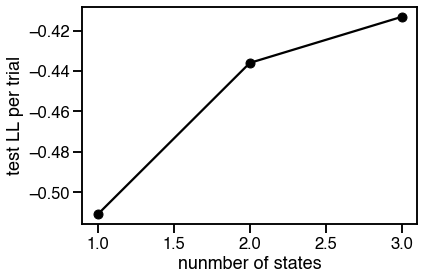

In [7]:
# Calculating test LL on the other half of all animal dataset and fit models
D = 4
x = np.load(f'../data_IBL/X_allAnimals_D={D}.npy')
y = np.load(f'../data_IBL/Y_allAnimals_D={D}.npy')
y = y.astype(int)
sessInd = np.load(f'../data_IBL/sessInd_allAnimals_D={D}.npy')
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data(x, y, sessInd, folds=2, blocks=10, random_state=1)
test_size = testX[0].shape[0]
testLl = np.zeros((3))
# evaluate log-likelihood on each test set
for K in [1,2,3]:
    
    # convert true weights into observation probabilities for each state
    phi = np.zeros((test_size,K,2))
    bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_allAnimals_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'rb'))
    for k in range(K):
        phi[:,k,:] = bestGLMHMM.glm.compObs(testX[0],bestGLMHMM.w[k,:,:])
    
    true_GLMHMM = glm_hmm.GLMHMM(test_size,D,2,K,observations="bernoulli")
    # compute true and inferred log-likelihoods
    testLl[K-1],_,_,_ = true_GLMHMM.forwardPass(testY[0],bestGLMHMM.A,phi)

plt.plot([1,2,3],testLl/test_size,'-o',color='black')
plt.ylabel("test LL per trial")
plt.xlabel("nunmber of states")
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
import scipy.io as sio
import seaborn as sns
import scipy.optimize
import pickle
sns.set_context("talk")

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils, analysis
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize

# code from Brody Summer Project
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, plotting_utils

sns.set_context("talk")

In [3]:
animalsIDs = ['W075','W081','W060','W089','W068','W073','W074','W080','W082','W088']
animalsInterest = ['W075','W081','W060','W089']
laptop_path = '/Users/lencacuturela/Desktop/Research/github/LC_PWM_GLM-HMM/data'

# Fitting GLM-HMM model with all animals together 

In [4]:
# According to Jonathan's suggestions for fitting global GLM-HMM for all animals

# stage filter changed from 3 to 4
# cutoff changed from 10 to 50
firstAnimal = 'W060'
x, y = io_utils.prepare_design_matrices(rat_id=firstAnimal, path=laptop_path, psychometric=True, cutoff=100, stage_filter=4, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=firstAnimal, path=laptop_path, psychometric=True, cutoff=100, stage_filter=4))

for animal in animalsIDs:
    if (animal != firstAnimal):
        xTemp, yTemp = io_utils.prepare_design_matrices(rat_id=animal, path=laptop_path, psychometric=True, cutoff=100, stage_filter=4, overwrite=False)
        sessIndTemp = list(io_utils.session_start(rat_id=animal, path=laptop_path, psychometric=True, cutoff=100, stage_filter=4))
        x = np.concatenate((x,xTemp))
        y = np.concatenate((y,yTemp))
        sessIndTemp = [x + sessInd[-1] for x in sessIndTemp[1:]]
        sessInd = sessInd + sessIndTemp
print(sessInd)
print(y.shape)
y = y.astype(int)

# NOT TAKING INTO ACCOUNT TO BREAK FORWARD-BACKWARD AT EACH SESSION LIKE IRIS DOES
    

KeyboardInterrupt: 

Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  20
Init  21
Init  22
Init  23
Init  24
Init  25
Init  26
Init  27
Init  28
Init  29


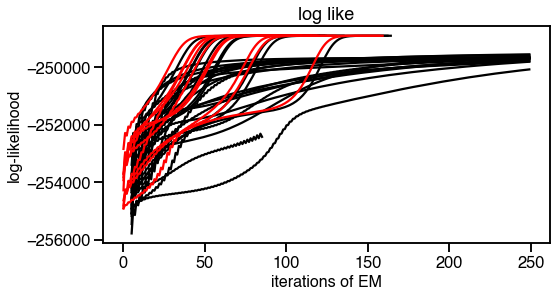

In [5]:
# Set hyperparameters
N = x.shape[0] # number of data/time points for the indirect pathway cohort
C = 2 # number of observation classes
D = x.shape[1] # number of GLM inputs (regressors)
K=2

inits = 30 # set the number of initializations - Iris has 50
maxiter = 250 # maximum number of iterations of EM to allow for each fit - Iris has 250
tol = 1e-4

# store values for each initialization
lls_all = np.zeros((inits,maxiter))
real_GLMHMMs = np.zeros((inits),dtype=object)

# fit the model for each initialization
for i in range(inits):
    print("Init ", i)
    real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
    # initialize the weights
    A_init, w_init, _ = real_GLMHMMs[i].generate_params(weights=['GLM',-0.2,1.2,x,y,1])
    # fit the model                     
    lls_all[i,:], A, w, pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
    
    # Check to see that multiple fits achieve the same log-likelihood 
fig, axes = plt.subplots(1,1)
fig.set_size_inches(8, 4)
topixs = visualize.plot_loglikelihoods(lls_all, maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
axes.set_title('log like')
    

# find the initialization that led to the best fit
bestix = find_best_fit(lls_all) 
best_GLMHMM = real_GLMHMMs[bestix]

# save the best fit - only for when large number of initializations and iterations!
pickle.dump(best_GLMHMM, open('GLMHMM__states-' + str(K) + '_weights-uniform.pickle', 'wb'))
    

[[0.9976 0.0024]
 [0.0026 0.9974]]
(2, 6, 2)


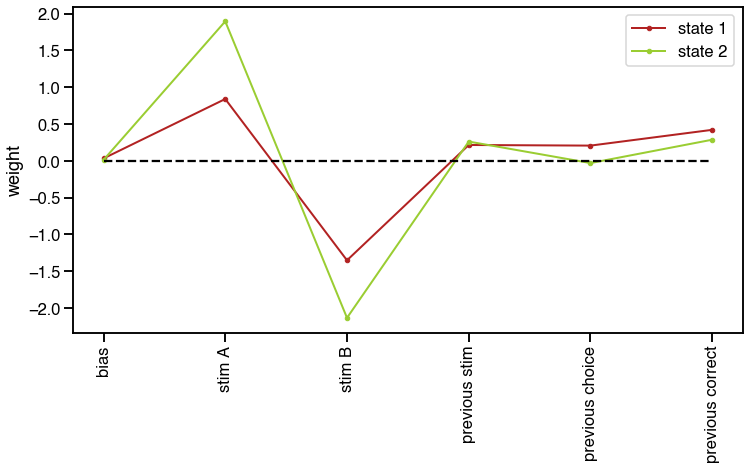

In [14]:
K = 2
best_GLMHMM = pickle.load(open('GLMHMM__states-' + str(K) + '_weights-uniform.pickle', 'rb'))
A = best_GLMHMM.A
print(np.round(A,4))
w = best_GLMHMM.w
print(w.shape)
xlabels = ['bias', 'stim A', 'stim B', 'previous stim', 'previous choice', 'previous correct']
legend = []
fig, axes = plt.subplots(1,figsize=(12,6))
for i in range(1,K+1):
    legend.append('state ' + str(i))
visualize.plot_weights(w[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-', color=my_colors,error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
axes.legend()



In [8]:
# checked that top ones match in parameters

# K = 2
# my_colors = ['firebrick','yellowgreen','mediumpurple','gold', 'cornflowerblue']
# for ind in topixs:
#     A = real_GLMHMMs[ind].A
#     print(A)
#     w = real_GLMHMMs[ind].w
#     xlabels = ['bias', 'stim A', 'stim B', 'previous stim', 'previous choice', 'previous correct']
#     legend = []
#     fig, axes = plt.subplots(1,figsize=(12,6))
#     for i in range(1,K+1):
#         legend.append('state ' + str(i))
#     visualize.plot_weights(w[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-',
#                 color=my_colors,error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
#     axes.legend()

    

# Fitting GLM-HMM for each animal individually

Animal  W075
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  20
Init  21
Init  22
Init  23
Init  24
Init  25
Init  26
Init  27
Init  28
Init  29
Animal  W081
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  20
Init  21
Init  22
Init  23
Init  24
Init  25
Init  26
Init  27
Init  28
Init  29
Animal  W068
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  20
Init  21
Init  22
Init  23
Init  24
Init  25
Init  26
Init  27
Init  28
Init  29
Animal  W060
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  1

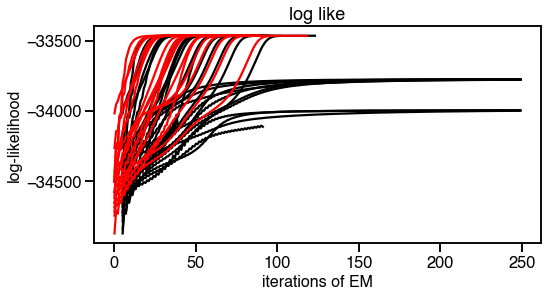

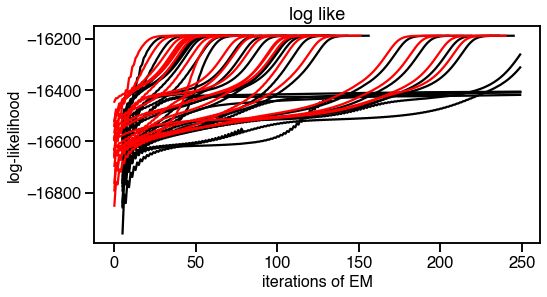

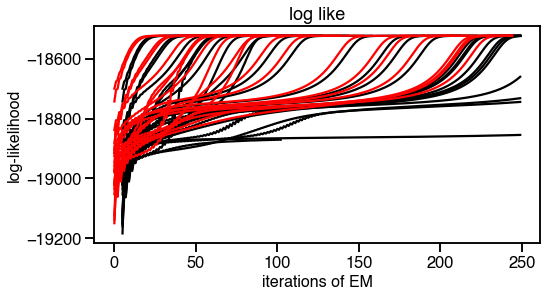

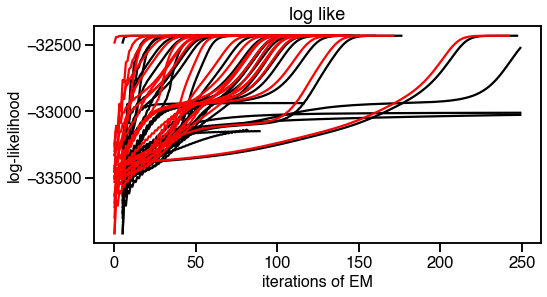

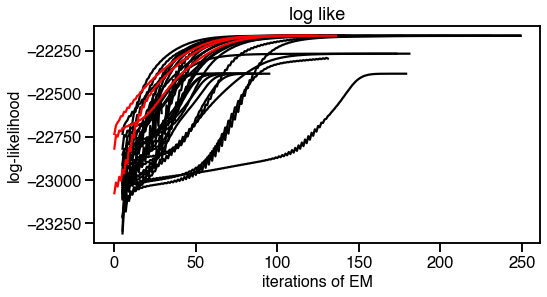

In [24]:
# 2 state fit 

for animal in ['W075','W081','W068','W060','W080']:
    print("Animal ", animal)
    x, y = io_utils.prepare_design_matrices(rat_id=animal, path=laptop_path, psychometric=True, cutoff=10, stage_filter=3, overwrite=False)
    sessInd = list(io_utils.session_start(rat_id=animal, path=laptop_path, psychometric=True, cutoff=10, stage_filter=3))

    # NOT LOOKING AT FULL DATASET
    sessStop = 250
    x = x[0:sessInd[sessStop]]
    y = y[0:sessInd[sessStop]]
    sessInd = sessInd[0:sessStop+1]

    # Set hyperparameters
    N = x.shape[0] # number of data/time points for the indirect pathway cohort
    C = 2 # number of observation classes
    D = x.shape[1] # number of GLM inputs (regressors)
    K=2

    inits = 30 # set the number of initializations - Iris has 50
    maxiter = 250 #250 # maximum number of iterations of EM to allow for each fit - Iris has 250
    tol = 1e-4

    # store values for each initialization
    lls_all = np.zeros((inits,maxiter))
    real_GLMHMMs = np.zeros((inits),dtype=object)

    # fit the model for each initialization
    for i in range(inits):
        print("Init ", i)
        real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
        # initialize the weights
        A_init, w_init, _ = real_GLMHMMs[i].generate_params(weights=['GLM',-2,2,x,y,1])
        # fit the model                     
        lls_all[i,:], A, w, pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
        # pickle.dump(real_GLMHMMs[i], open(f'models/GLMHMM_{animal}_states-{K}_weights-GLM_init-{i}.pickle', 'wb'))
        
    # Check to see that multiple fits achieve the same log-likelihood 
    fig, axes = plt.subplots(1,1)
    fig.set_size_inches(8, 4)
    topixs = visualize.plot_loglikelihoods(lls_all, maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
    axes.set_title('log like')
        
    # find the initialization that led to the best fit
    bestix = find_best_fit(lls_all) 
    best_GLMHMM = real_GLMHMMs[bestix]

    # save the best fit - only for when large number of initializations and iterations!
    pickle.dump(best_GLMHMM, open(f'models/bestGLMHMM_{animal}_states-{K}_weights-GLM_untilSession250.pickle', 'wb'))
    
    

[[0.9977 0.0023]
 [0.0024 0.9976]]
(2, 6, 2)


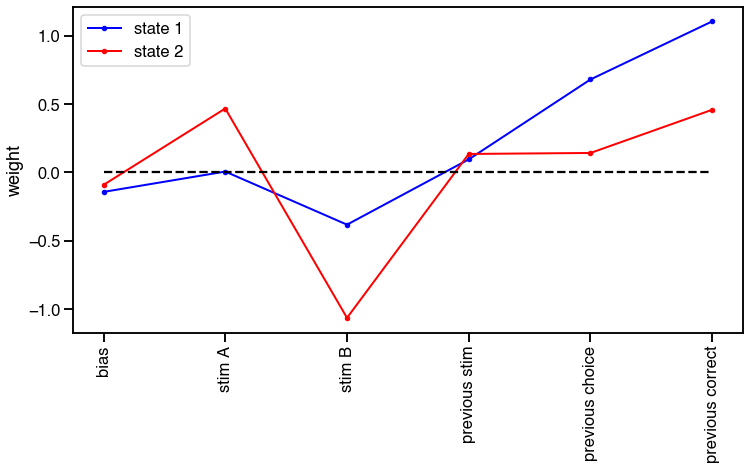

In [14]:
import pickle
K = 2
animal = 'W081'
best_GLMHMM = pickle.load(open(f'models/bestGLMHMM_{animal}_states-{K}_weights-GLM_untilSession250.pickle', 'rb'))
A = best_GLMHMM.A
print(np.round(A,4))
w = best_GLMHMM.w
print(w.shape)
xlabels = ['bias', 'stim A', 'stim B', 'previous stim', 'previous choice', 'previous correct']
legend = []
fig, axes = plt.subplots(1,figsize=(12,6))
for i in range(1,K+1):
    legend.append('state ' + str(i))
visualize.plot_weights(w[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-', color=['blue','red'],error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
axes.legend()

In [26]:
# 3 state fit

for animal in ['W075','W081','W068','W060','W080']:
    print("Animal ", animal)
    x, y = io_utils.prepare_design_matrices(rat_id=animal, path=laptop_path, psychometric=True, cutoff=10, stage_filter=3, overwrite=False)
    sessInd = list(io_utils.session_start(rat_id=animal, path=laptop_path, psychometric=True, cutoff=10, stage_filter=3))

    # NOT LOOKING AT FULL DATASET
    sessStop = 250
    x = x[0:sessInd[sessStop]]
    y = y[0:sessInd[sessStop]]
    sessInd = sessInd[0:sessStop+1]

    # Set hyperparameters
    N = x.shape[0] # number of data/time points for the indirect pathway cohort
    C = 2 # number of observation classes
    D = x.shape[1] # number of GLM inputs (regressors)
    K=3

    inits = 30 # set the number of initializations - Iris has 50
    maxiter = 250 #250 # maximum number of iterations of EM to allow for each fit - Iris has 250
    tol = 1e-4

    # store values for each initialization
    lls_all = np.zeros((inits,maxiter))
    real_GLMHMMs = np.zeros((inits),dtype=object)

    # fit the model for each initialization
    for i in range(inits):
        print("Init ", i)
        real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
        # initialize the weights
        A_init, w_init, _ = real_GLMHMMs[i].generate_params(weights=['GLM',-2,2,x,y,1])
        # fit the model                     
        lls_all[i,:], A, w, pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
        # pickle.dump(real_GLMHMMs[i], open(f'models/GLMHMM_{animal}_states-{K}_weights-GLM_init-{i}.pickle', 'wb'))
        
    # Check to see that multiple fits achieve the same log-likelihood 
    fig, axes = plt.subplots(1,1)
    fig.set_size_inches(8, 4)
    topixs = visualize.plot_loglikelihoods(lls_all, maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
    axes.set_title('log like')
        
    # find the initialization that led to the best fit
    bestix = find_best_fit(lls_all) 
    best_GLMHMM = real_GLMHMMs[bestix]

    # save the best fit - only for when large number of initializations and iterations!
    pickle.dump(best_GLMHMM, open(f'models/bestGLMHMM_{animal}_states-{K}_weights-GLM_untilSession250.pickle', 'wb'))


Animal  W075
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18


# Loading previously fit models and saving weight and transition matrix in dGLM-HMM1 format

In [20]:
# saving parameters for best initializations in the format of dGLM-HMM1
animalsCurrent = ['W075','W060']
for animal in animalsCurrent:
    print("Animal ", animal)
    K = 3
    x, y = io_utils.prepare_design_matrices(rat_id=animal, path=laptop_path, psychometric=True, cutoff=10, stage_filter=3, overwrite=False)
    sessInd = list(io_utils.session_start(rat_id=animal, path=laptop_path, psychometric=True, cutoff=10, stage_filter=3))

    # NOT LOOKING AT FULL DATASET
    sessStop = 250
    x = x[0:sessInd[sessStop]]
    y = y[0:sessInd[sessStop]]
    sessInd = sessInd[0:sessStop+1]
    
    GLMHMM = pickle.load(open(f'models/bestGLMHMM_{animal}_states-{K}_weights-GLM_untilSession250.pickle', 'rb'))
    wTemp = GLMHMM.w
    wTemp[:,:,:] = - wTemp[:,:,:] # all weights have opposite sign in my code vs Iris'
    w = np.repeat(wTemp[np.newaxis], sessInd[-1], axis=0)
    print(wTemp[:,:,1])
    print(GLMHMM.A)
    np.save(f'../data_PWM/W_PWM_bestGLMHMM-Iris_{animal}_sf=3_{K}_state_untilSession250', w)
    np.save(f'../data_PWM/P_PWM_bestGLMHMM-Iris_{animal}_sf=3_{K}_state_untilSession250', GLMHMM.A)

    # fig, axes = plt.subplots()
    # s = sns.heatmap(np.round(GLMHMM.A,4),annot=True,cmap='BuPu', fmt='g')
    # s.set(xlabel='state at time t+1', ylabel='state at time t', title='Recovered transition matrix P', xticklabels=[1,2], yticklabels=[1,2])
    # fig = s.get_figure()
            

Animal  W075
[[ 1.39138829e+00 -5.13034219e-01  6.17165558e-01 -1.43449726e-01
  -9.76752988e-02 -1.02671472e+00]
 [ 1.65429900e-03 -1.55434501e-01  6.77383352e-01 -1.44734846e-01
  -6.18781791e-01 -8.41291127e-01]
 [-1.89968384e+00 -3.16290108e+00  4.88453841e+00 -2.71291777e-01
  -2.58997077e-01 -1.57585319e-01]]
[[5.03524872e-01 3.59722321e-03 4.92877905e-01]
 [2.91965483e-03 9.96384079e-01 6.96266193e-04]
 [3.12642372e-01 1.94162066e-04 6.87163466e-01]]
Animal  W060
[[-1.55853322 -2.82139957  5.1636594  -0.48685394 -0.06454648 -0.09533698]
 [ 0.40774889 -1.92096213  1.71863702 -0.23099767  0.1792476  -0.31476412]
 [-0.16864131 -0.34062733  0.94374096 -0.22600537 -0.2775478  -0.32508956]]
[[5.45088609e-01 4.49455584e-01 5.45580718e-03]
 [2.23142101e-01 7.76830785e-01 2.71138109e-05]
 [5.68641863e-03 1.50928827e-07 9.94313430e-01]]


In [15]:
# Finding best initialization for TEST SET ALONE

# from utils import *
# from plotting_utils import *
# from analysis_utils import *
# animalsCurrent = ['W068','W075','W068','W081','W089']
# for rat_id in ['W075']: #animalsCurrent:
#     inits = 40
#     path=laptop_path
#     fold = 0
#     stage_filter = 3
#     folds = 4
#     x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
#     sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
#     trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=folds, random_state=1)
#     D = trainX[0].shape[1]
#     C = 2 # only looking at binomial classes
#     K = 2

#     oldSessInd = [0, allW[2].shape[0]]
#     testLlInit = np.zeros((inits))
#     N = trainX[fold].shape[0]
#     dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
#     trainY[fold] = trainY[fold].astype(int)
#     testY[fold] = testY[fold].astype(int)

#     # evaluating for each initialization
#     for i in range(0,inits):
#     # evaluate
#         for ind in range(0,9):
#             sess = len(testSessInd[fold]) - 1 # number sessions
#             testPhi = dGLM_HMM.observation_probability(testX[fold], reshapeWeights(allW[ind], oldSessInd, testSessInd[fold], True))
#             for s in range(0, sess):
#                 # evaluate on test data for each session separately
#                 _, _, temp = dGLM_HMM.forward_pass(testY[fold][testSessInd[fold][s]:testSessInd[fold][s+1]],allP[ind],testPhi[testSessInd[fold][s]:testSessInd[fold][s+1]])
#                 testLlInit[ind] += temp

#     testLlInit = testLlInit / testSessInd[fold][-1] # normalizing to the total number of trials in test dataset
#     print(testLlInit)
#     print(finalLl.shape)
#     trainLlInit = finalLl 
#     print(trainLlInit)